# 請結合前面的知識與程式碼，比較不同的 optimizer 與 learning rate 組合對訓練的結果與影響
### 常見的 optimizer 包含
* SGD
* RMSprop
* AdaGrad
* Adam

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    """
    Build your own model
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
"""
Set your required experiment parameters
"""
LEARNING_RATE = [0.01, 0.001]
EPOCHS = 40
BATCH_SIZE = 256
MOMENTUM = 0.95

In [8]:
sgd_0 = keras.optimizers.SGD(lr=LEARNING_RATE[0], nesterov=True, momentum=MOMENTUM)
rmsprop_0 = keras.optimizers.RMSprop(lr=LEARNING_RATE[0], rho=0.9, epsilon=None, decay=0.0)
adagrad_0 = keras.optimizers.Adagrad(lr=LEARNING_RATE[0], epsilon=None, decay=0.0)
adam_0  = keras.optimizers.Adam(lr=LEARNING_RATE[0], beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

sgd_1 = keras.optimizers.SGD(lr=LEARNING_RATE[1], nesterov=True, momentum=MOMENTUM)
rmsprop_1 = keras.optimizers.RMSprop(lr=LEARNING_RATE[1], rho=0.9, epsilon=None, decay=0.0)
adagrad_1 = keras.optimizers.Adagrad(lr=LEARNING_RATE[1], epsilon=None, decay=0.0)
adam_1  = keras.optimizers.Adam(lr=LEARNING_RATE[1], beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)


'''
sgd = []
for lr in LEARNING_RATE:
    sgd[LEARNING_RATE.index(lr)] = keras.optimizers.SGD(lr=lr, nesterov=True, momentum=MOMENTUM)
    rmsprop = keras.optimizers.RMSprop(lr=lr, rho=0.9, epsilon=None, decay=0.0)
    adagrad = keras.optimizers.Adagrad(lr=lr, epsilon=None, decay=0.0)
    adam  = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    
'''
OPTIMIZER = [sgd_0, rmsprop_0, adagrad_0, adam_0, sgd_1, rmsprop_1, adagrad_1, adam_1]

Instructions for updating:
Colocations handled automatically by placer.


In [20]:
keras.backend.clear_session()

In [11]:
results = {}

"""
建立你的訓練與實驗迴圈並蒐集資料
"""
for lr in LEARNING_RATE:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    # print("Experiment with LR = %.6f" % (lr))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    
    sgd = keras.optimizers.SGD(lr=lr, nesterov=True, momentum=MOMENTUM)
    '''
    rmsprop = keras.optimizers.RMSprop(lr=LEARNING_RATE[0], rho=0.9, epsilon=None, decay=0.0)
    adagrad = keras.optimizers.Adagrad(lr=LEARNING_RATE[0], epsilon=None, decay=0.0)
    adam  = keras.optimizers.Adam(lr=LEARNING_RATE[0], beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    '''
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=sgd)

    model.fit(x_train, y_train,
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test),
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-lr-%s" % str(lr)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/40
50000/50000 [==============================] - 11s 219us/step - loss: 1

50000/50000 [==============================] - 10s 194us/step - loss: 1.6602 - acc: 0.4195 - val_loss: 1.6396 - val_acc: 0.4239
Epoch 5/40
50000/50000 [==============================] - 10s 200us/step - loss: 1.6133 - acc: 0.4350 - val_loss: 1.6037 - val_acc: 0.4353
Epoch 6/40
50000/50000 [==============================] - 10s 200us/step - loss: 1.5752 - acc: 0.4486 - val_loss: 1.5817 - val_acc: 0.44531.5757 - acc: 0.448
Epoch 7/40
50000/50000 [==============================] - 10s 198us/step - loss: 1.5401 - acc: 0.4586 - val_loss: 1.5396 - val_acc: 0.4604
Epoch 8/40
50000/50000 [==============================] - 10s 201us/step - loss: 1.5113 - acc: 0.4698 - val_loss: 1.5263 - val_acc: 0.4596
Epoch 9/40
50000/50000 [==============================] - 10s 206us/step - loss: 1.4846 - acc: 0.4783 - val_loss: 1.5073 - val_acc: 0.4667
Epoch 10/40
50000/50000 [==============================] - 10s 199us/step - loss: 1.4592 - acc: 0.4882 - val_loss: 1.4868 - val_acc: 0.4767
Epoch 11/40
50000/

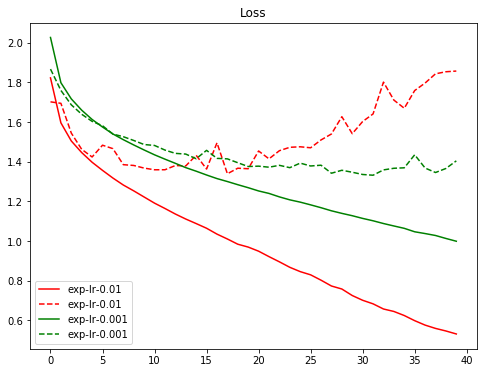

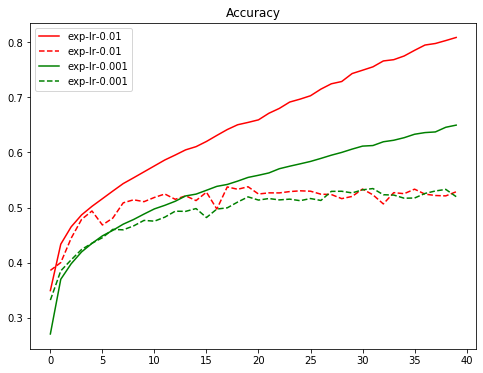

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()